In [1]:
import psycopg2
import pandas as pd
import numpy as np
import mariadb
import json
import os
import shutil
import subprocess
from pathlib import Path
import pyodbc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [2]:
analysisDetails = pd.read_csv("output/analysis_chemicals.csv")

In [3]:
analysisDetails.analysis_name = [ i.replace(":","") for i in analysisDetails.analysis_name ]

In [4]:
analysisDetails['chemical_name'] = [ i.replace("'","").replace("[","").replace("]","").split(",") for i in analysisDetails['chemical_name'] ]

In [5]:
analysisDetails = analysisDetails.set_index("analysis_name")

In [6]:
analysisDetails = analysisDetails.to_dict()['chemical_name']

In [7]:
sgf_df = pd.read_csv("output/sgf_analysis_cleaned.csv")

In [8]:
sgf_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,sample_code,batch_date,analysis_name,chemical_name,result,unit_name
0,9,347627,347627,CE032SGF1242,2023-03-27 09:04:50.000,1:2 Soil Volume Extract,magnesium,5.79,ppm
1,280,348875,348875,CB110SGF0084,2023-03-28 10:09:22.667,1:2 Soil Volume Extract,magnesium,13.30,ppm
2,330,348692,348692,CB110SGF0088,2023-03-28 10:09:22.667,1:2 Soil Volume Extract,magnesium,4.81,ppm
3,343,348861,348861,CB110SGF0082,2023-03-28 10:09:22.667,1:2 Soil Volume Extract,magnesium,31.80,ppm
4,345,348655,348655,CB110SGF0087,2023-03-28 10:09:22.667,1:2 Soil Volume Extract,magnesium,0.51,ppm
...,...,...,...,...,...,...,...,...,...
723604,435170,377800,377800,CM173SGF1947,2023-05-02 12:44:00.000,Raw irrigation water analysis (for fertigation),electrical_conductivity,0.39,mS cm -1
723605,333316,89923,89923,CG019SGF0253,2020-07-14 15:59:00.000,Raw irrigation water analysis (for fertigation),ph,7.32,cfu/100 ml
723606,333472,90356,90356,CG019SGF0254,2020-07-14 15:59:00.000,Raw irrigation water analysis (for fertigation),ph,7.83,cfu/100 ml
723607,333738,233359,233359,CB110SGF0036,2020-07-15 12:58:00.000,Raw irrigation water analysis (for fertigation),ph,6.61,cfu/100 ml


In [9]:
sgf_df.analysis_name.value_counts().to_csv("output/analysis_value_counts.csv")

In [10]:
sgf_df.analysis_name = [ str(i).strip() for i in sgf_df.analysis_name]

In [11]:
sgf_df['analysis_name'] = [i.replace(":","") for i in sgf_df['analysis_name']]
sgf_df['result'] = [ float(str(i).replace("<","").replace(">","")) for i in sgf_df['result'] ]

In [12]:
sgf_df.sort_values('batch_date')

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,sample_code,batch_date,analysis_name,chemical_name,result,unit_name
139895,87094,30016,30016,CG044SGF0002,2010-11-26 00:00:00.000,12 Soil Volume Extract,zinc,0.010,ppm
616428,87139,30051,30051,CG044SGF0004,2010-11-26 00:00:00.000,12 Soil Volume Extract,manganese,0.780,ppm
267425,87156,30042,30042,CG044SGF0004,2010-11-26 00:00:00.000,12 Soil Volume Extract,electrical_conductivity,0.240,mS/cm
267424,87124,30006,30006,CG044SGF0002,2010-11-26 00:00:00.000,12 Soil Volume Extract,electrical_conductivity,0.710,mS/cm
267423,87120,30001,30001,CG044SGF0001,2010-11-26 00:00:00.000,12 Soil Volume Extract,electrical_conductivity,0.590,mS/cm
...,...,...,...,...,...,...,...,...,...
94190,87075,405685,405685,CT017SGF0380,2024-11-14 13:00:06.607,12 Soil Volume Extract,nitrate_n,7.890,ppm
284614,87073,405687,405687,CT017SGF0380,2024-11-14 13:00:06.607,12 Soil Volume Extract,sulphur,55.300,ppm
407315,87070,406133,406133,CT017SGF0380,2024-11-14 13:00:06.607,12 Soil Volume Extract,bicarbonate,14.500,ppm
109340,87076,405684,405684,CT017SGF0380,2024-11-14 13:00:06.607,12 Soil Volume Extract,phosphorus,4.050,ppm


In [13]:
new_samples_df = sgf_df.loc[sgf_df['batch_date'] > '2024-08-21'] 
sgf_df = sgf_df.loc[sgf_df['batch_date'] <= '2024-08-21'] 

In [14]:
new_samples_df.analysis_name.value_counts()

analysis_name
12 Soil Volume Extract                             12232
Drip Water Analysis                                 6630
Raw irrigation water analysis (for fertigation)      255
Name: count, dtype: int64

In [15]:
sgf_df.analysis_name.value_counts()

analysis_name
12 Soil Volume Extract                             638896
Drip Water Analysis                                 62189
Raw irrigation water analysis (for fertigation)      3407
Name: count, dtype: int64

In [16]:
sgf_df.analysis_name.value_counts().to_csv("output/modelling_analysis_value_counts.csv")
new_samples_df.analysis_name.value_counts().to_csv("output/test_analysis_value_counts.csv")

In [17]:
os.makedirs("output/analysis",exist_ok=True)
os.makedirs("output/chemical_null_count",exist_ok=True)

for analysis in np.unique(sgf_df['analysis_name']):
    print(analysis)
    df_ = sgf_df.loc[sgf_df['analysis_name']==analysis]
    print(df_.chemical_name.unique())
    
    df_ = pd.pivot_table(data=df_, values="result", index="sample_code", columns="chemical_name")
    df_ = df_[[ j.strip() for j in analysisDetails[analysis] if j.strip() in df_.columns]]
    os.makedirs(f"output/boxplots/{analysis}",exist_ok=True)
    for column in df_.columns:        
        plt.boxplot(df_[column])
        plt.savefig(f"output/boxplots/{analysis}/{column}.png")
        plt.clf()
        outlier_threshold = df_[column].quantile(0.99)
        # df_ = df_.loc[df_[column] <= outlier_threshold]

    if len(df_.columns) == 0:
        continue
    df_.describe().to_csv(f"output/chemical_null_count/{analysis}.csv")
    
    df_.to_csv(f"output/analysis/{analysis}.csv")


12 Soil Volume Extract
['magnesium' 'calcium' 'ammonium' 'sulphur' 'sodium' 'potassium'
 'nitrate_n' 'phosphorus' 'bicarbonate' 'zinc' 'molybdenum' 'boron'
 'copper' 'manganese' 'iron' 'silicon__' 'chloride' 'chlorides' 'nitrates'
 'electrical_conductivity']
Drip Water Analysis
['nitrate_n' 'molybdenum' 'sulphur' 'manganese' 'magnesium' 'phosphorus'
 'iron' 'potassium' 'copper' 'calcium' 'sodium' 'zinc' 'bicarbonate'
 'boron' 'ammonium' 'silicon__' 'chloride' 'nitrates' 'chlorides']
Raw irrigation water analysis (for fertigation)
['bicarbonate' 'sulphur' 'magnesium' 'copper' 'boron' 'nitrate_n' 'zinc'
 'iron' 'chloride' 'potassium' 'calcium' 'molybdenum' 'manganese'
 'ammonium' 'phosphorus' 'sodium' 'silicon__' 'nitrates'
 'electrical_conductivity' 'ph']


<Figure size 640x480 with 0 Axes>

In [18]:
os.makedirs("./output/analysis_imputed",exist_ok=True)
os.makedirs("./output/pca_plots",exist_ok=True)
os.makedirs("./output/pca_df",exist_ok=True)
os.makedirs("./output/analysis_scaled",exist_ok=True)

In [19]:
os.makedirs("./models/imputers",exist_ok=True)
os.makedirs("./models/scalers",exist_ok=True)
os.makedirs("./models/pca",exist_ok=True)

12 Soil Volume Extract.csv
Number of components explaining 95% variance: 14
Drip Water Analysis.csv
Number of components explaining 95% variance: 13
Raw irrigation water analysis (for fertigation).csv
Number of components explaining 95% variance: 8


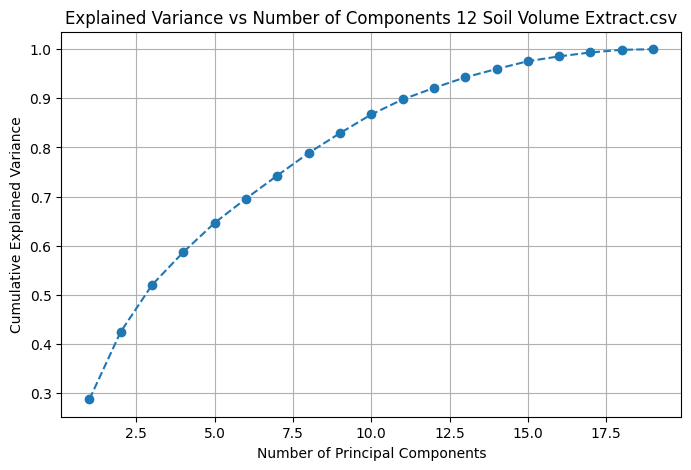

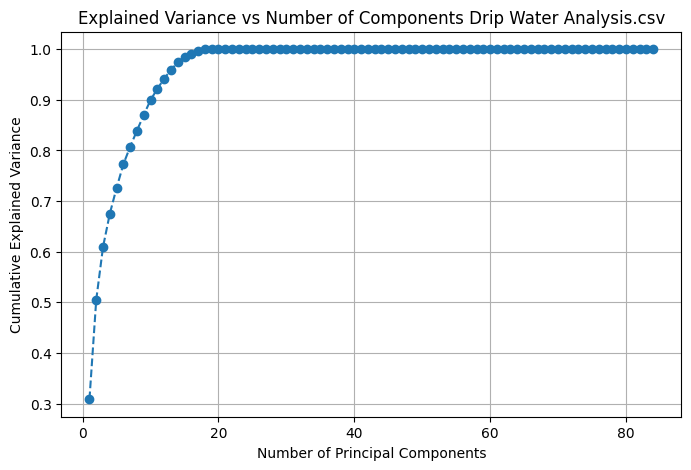

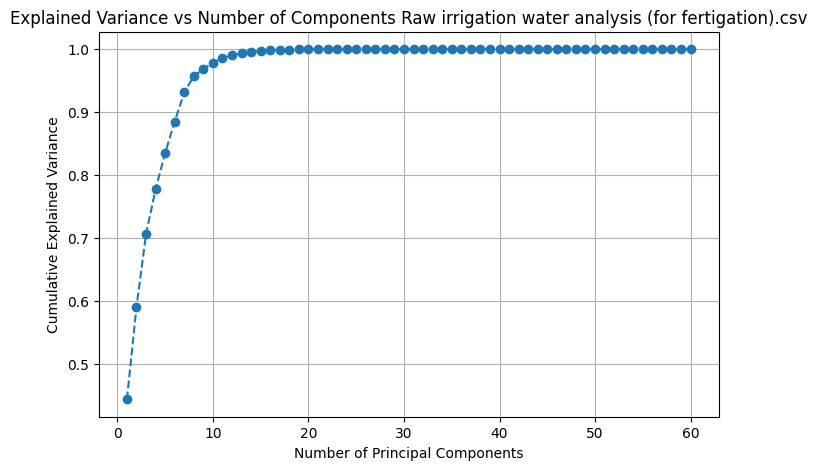

In [20]:
for analysis_file in os.listdir("output/analysis"):
    print(analysis_file)
    analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
    analysis_df = analysis_df.loc[analysis_df.index.isin(sgf_df.sample_code)]
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    # analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), columns=analysis_df.columns, index=analysis_df.index)
    analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), index=analysis_df.index)
    analysis_df.to_csv(f"./output/analysis_imputed/{analysis_file}")
    pickle.dump(imp_mean, open(f"models/imputers/{analysis_file.replace('csv','pkl')}","wb"))
    # if(len(analysis_df) == 0):
    #     continue
    if(len(analysis_df.columns) == 1):
        continue
    sc = StandardScaler()
    pca = PCA()
    analysis_scaled = sc.fit_transform(analysis_df)
    pca.fit(analysis_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance vs Number of Components {analysis_file}')
    plt.grid(True)
    plt.savefig(f"./output/pca_plots/{analysis_file.replace('.csv','.png')}")
    n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f'Number of components explaining 95% variance: {n_components}')
    
    pca = PCA(n_components=n_components)
    pca_reduced_df = pca.fit_transform(analysis_scaled)
    analysis_scaled = pd.DataFrame(analysis_scaled,index=analysis_df.index)
    analysis_scaled.to_csv(f"output/analysis_scaled/{analysis_file}")
    np.save(f"output/pca_df/{analysis_file.replace('.csv','')}", pca_reduced_df)
    pickle.dump(sc, open(f"models/scalers/{analysis_file.replace('csv','pkl')}","wb"))
    pickle.dump(pca, open(f"models/pca/{analysis_file.replace('csv','pkl')}","wb"))

In [21]:
os.makedirs("./output/mahalanobis_distance",exist_ok=True)

In [22]:
for analysis_file in os.listdir("output/pca_df"):
    print(analysis_file)
    pca_reduced_df = pd.DataFrame(np.load(f"output/pca_df/{analysis_file}"))
    if len(pca_reduced_df.columns) <= 2:
        continue
    mu = np.mean(pca_reduced_df, axis=0)
    sigma = np.cov(pca_reduced_df.T)
    pca_reduced_df['mahalanobis_distance'] = [distance.mahalanobis(pca_reduced_df.iloc[i], mu, np.linalg.inv(sigma)) for i in range(len(pca_reduced_df)) ]

    pd.DataFrame(pca_reduced_df).to_csv(f"output/mahalanobis_distance/{analysis_file.replace('.npy','')}.csv")

12 Soil Volume Extract.npy
Drip Water Analysis.npy
Raw irrigation water analysis (for fertigation).npy


In [23]:
os.makedirs("output/mahanobis_distance_upper_quantile",exist_ok=True)
os.makedirs("output/mahalanobis_boxplots",exist_ok=True)

In [24]:
mahalanobis_threshold_dict = {}
for analysis_file in os.listdir("output/mahalanobis_distance"):
    print(analysis_file)
    analysis = analysis_file.replace(".csv","")
    mahalanobis_df = pd.read_csv(f"output/mahalanobis_distance/{analysis_file}",index_col=0)
    upper_quantile = (mahalanobis_df['mahalanobis_distance'].quantile(0.95))
    mahalanobis_threshold_dict[analysis_file.replace(".csv","")] = upper_quantile
    mahalanobis_df.loc[mahalanobis_df['mahalanobis_distance'] >= upper_quantile].to_csv(f"output/mahanobis_distance_upper_quantile/{analysis_file}")
    plt.boxplot(mahalanobis_df['mahalanobis_distance'])
    plt.axhline(y=upper_quantile, color='red', linestyle='--', label=f'Threshold at {upper_quantile}')
    plt.title(f"Mahalanobis Threshold = {round(upper_quantile,2)}")
    plt.savefig(f"output/mahalanobis_boxplots/{analysis}.png")
    plt.clf()
pickle.dump(mahalanobis_threshold_dict, open("mahalanobis_thresholds.dict","wb"))

12 Soil Volume Extract.csv
Drip Water Analysis.csv
Raw irrigation water analysis (for fertigation).csv


<Figure size 640x480 with 0 Axes>

In [25]:
pd.DataFrame({'analysis_name':(mahalanobis_threshold_dict.keys())}).to_csv("output/analysis_names_send_to_thomas_and_josephine.csv")

In [26]:
conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [27]:
reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']
reverse_analysis_dict

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31696\3771434913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']


{'% Gypsum': 540,
 '% Nitrogen (RSSP 2)': 647,
 '% Organic Matter': 258,
 '% Organic Matter (RSSP 2)': 646,
 '% Soil Nitrogen': 18,
 '%Assay': 27490,
 '%N (RSSP 2)': 652,
 '%OM (RSSP 2)': 651,
 '%P,%S Analysis(Super Calcium)': 383,
 '1:2 Soil Volume Extract': 294,
 '1:2 soil volume extract': 25,
 '1:2 Soil Volume Extract (Data Only)': 27339,
 '1:2 Vol Extract for BLGG': 317,
 '20:12:12 (N,P205,K20) Analysis': 840,
 'Absorbance at 254nm': 26936,
 'Acid Detergent Fibre': 27063,
 'Acid Insoluble Ash': 27417,
 'Acid Insoluble Matter': 27108,
 'Acid titration': 26647,
 'Acid Value': 26971,
 'Advanced Biological Farming Soil Audit': 26521,
 'Advanced Soil Health Analysis': 27181,
 'Aerobic Mesophilic Count': 26649,
 'Aflatoxin': 26794,
 'Aflatoxin AFB1': 26938,
 'Aflatoxin B1': 26939,
 'Aflatoxin in feed': 767,
 'Aflatoxin M1': 27469,
 'Aflatoxin Total': 766,
 'AfSIS Standard Leaf Analysis': 633,
 'AFSIS Std Wet Chemistry Soil Analysis': 589,
 'Aggregate Stability': 26727,
 'Agrifi Soil Micr

In [28]:
for analysis in reverse_analysis_dict.copy().keys():
    if ":" in analysis:
        reverse_analysis_dict[analysis.replace(":","")] = reverse_analysis_dict[analysis]

In [29]:
test = []

In [30]:
new_samples_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,sample_code,batch_date,analysis_name,chemical_name,result,unit_name
1760,73101,447067,447067,CW007SGF0052,2024-08-23 12:10:00.000,12 Soil Volume Extract,magnesium,6.040,ppm
1761,73126,425721,425721,CW007SGF0049,2024-08-23 12:10:00.000,12 Soil Volume Extract,magnesium,8.570,ppm
1762,73134,446996,446996,CW007SGF0050,2024-08-23 12:10:00.000,12 Soil Volume Extract,magnesium,7.300,ppm
1763,73146,447027,447027,CW007SGF0051,2024-08-23 12:10:00.000,12 Soil Volume Extract,magnesium,8.480,ppm
1764,73196,445138,445138,CG065SGF0309,2024-08-26 10:25:36.930,12 Soil Volume Extract,magnesium,25.000,ppm
...,...,...,...,...,...,...,...,...,...
723443,85473,448820,448820,CS032SGF0394,2024-10-31 15:09:20.023,Raw irrigation water analysis (for fertigation),electrical_conductivity,0.140,mS cm -1
723444,85977,449328,449328,CM173SGF3315,2024-11-04 14:30:00.000,Raw irrigation water analysis (for fertigation),electrical_conductivity,0.400,mS cm -1
723445,86232,433382,433382,CR009SGF0035,2024-11-07 12:17:00.000,Raw irrigation water analysis (for fertigation),electrical_conductivity,0.034,mS cm -1
723446,86678,426722,426722,CM173SGF3347,2024-11-11 11:09:00.000,Raw irrigation water analysis (for fertigation),electrical_conductivity,0.420,mS cm -1


In [31]:
for sample in new_samples_df.sample_code.unique():
    res = {}
    tmp_ = new_samples_df.loc[new_samples_df.sample_code == sample]
    res['sample_code'] = sample
    print([ i for i in tmp_.analysis_name.unique() ])
    res['analysis_id'] = [ reverse_analysis_dict[i] for i in tmp_.analysis_name.unique() if i in reverse_analysis_dict.keys() ]
    for index,row in tmp_.iterrows():
        if row['result'] >= 0 :
            res[row['chemical_name']] = {'result': row['result'], 'units': str(row['unit_name'])}
        else:
            res[row['chemical_name']] = {'result': 0, 'units': row['unit_name']}
    test.append(res)    


['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
['12 Soil Volume Extract']
[

In [32]:
test

[{'sample_code': 'CW007SGF0052',
  'analysis_id': [294],
  'magnesium': {'result': 6.04, 'units': 'ppm'},
  'calcium': {'result': 14.9, 'units': 'ppm'},
  'ammonium': {'result': 6.62, 'units': 'ppm'},
  'sulphur': {'result': 8.29, 'units': 'ppm'},
  'sodium': {'result': 1.11, 'units': 'ppm'},
  'potassium': {'result': 73.5, 'units': 'ppm'},
  'nitrate_n': {'result': 26.3, 'units': 'ppm'},
  'phosphorus': {'result': 1.31, 'units': 'ppm'},
  'bicarbonate': {'result': 21.3, 'units': 'ppm'},
  'zinc': {'result': 0.01, 'units': 'ppm'},
  'molybdenum': {'result': 0.012, 'units': 'ppm'},
  'boron': {'result': 0.11, 'units': 'ppm'},
  'copper': {'result': 0.019, 'units': 'ppm'},
  'manganese': {'result': 0.018, 'units': 'ppm'},
  'iron': {'result': 0.6, 'units': 'ppm'},
  'silicon__': {'result': 10.0, 'units': 'ppm'},
  'chloride': {'result': 20.0, 'units': 'ppm'},
  'nitrates': {'result': 116.0, 'units': 'ppm'},
  'electrical_conductivity': {'result': 0.38, 'units': 'mS/cm'}},
 {'sample_code'

In [33]:
reverse_analysis_dict['1:2 Soil Volume Extract'] 

294

In [34]:
analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31696\132348878.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']


In [35]:
pickle.dump(analysis_dict, open("analysis.dict","wb"))

In [36]:
analysis_dict = pickle.load(open("analysis.dict","rb"))

In [37]:
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

In [38]:
pd.DataFrame({'analysis_name':mahalanobis_thresholds.keys()}).to_csv("output/analyses_in_models.csv")

In [39]:
unit_decision = pd.read_csv("output/sgf_unit_per_chemical_decision.csv")

In [42]:
req_body = test
_ = pd.DataFrame(req_body)
unit_decision = pd.read_csv("output/sgf_unit_per_chemical_decision.csv")
unit_decision.analysis_name = [ i.replace(":","") for i in unit_decision.analysis_name ]
analysis_dict = pickle.load(open("analysis.dict","rb"))
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

result = {}
_df = _.explode('analysis_id', ignore_index=True)
import math
for index,row in _df.iterrows():
    sample_code = row['sample_code']
    print(sample_code)
    if sample_code not in result.keys():
        result[sample_code] = []
    if math.isnan(row['analysis_id']):
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in specified", "details": f"Analysis id not provided", "analysis": None  })   
        continue
    row['analysis_name'] = analysis_dict[row['analysis_id']]
    analysis = row['analysis_name'].replace(":","")
    analysis_id = row['analysis_id']
    if analysis not in mahalanobis_thresholds.keys():
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in models", "details": f"Analysis: {analysis} is not in the list of defined models", "analysis": row['analysis_name'] })   
        continue  
    row = row.dropna()
    scaler = pickle.load(open(f"models/scalers/{analysis}.pkl","rb"))
    pca = pickle.load(open(f"models/pca/{analysis}.pkl","rb"))
    imputer = pickle.load(open(f"models/imputers/{analysis}.pkl","rb"))
    analysis_df = pd.read_csv(f"output/analysis/{analysis}.csv",index_col=0)
    mahalanobis_distance_df = pd.read_csv(f"output/mahalanobis_distance/{analysis}.csv",index_col=0).drop("mahalanobis_distance",axis=1)

    

    try :
        tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    except Exception as e:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Missing parameters for analysis: {analysis}", "details": f"Missing parameters: {','.join([ i for i in analysis_df.columns if i not in row.dropna().index])} for analysis: {analysis}", "analysis": row['analysis_name']})
        continue
    failed_units_comparison = {}    
    for col in tmp_df.columns:
        expected_units = unit_decision.loc[(unit_decision['analysis_name'] == analysis) & (unit_decision['chemical_name'] == col)]
        print(expected_units)
        print(col)
        print(analysis)
        import math
        if type(row[col]) != dict and math.isnan(row[col]):
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = None
        elif row[col]['units'] !=   expected_units['unit_name'].values[0] :
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = row[col]['units']
        else:
            continue    
    if len(failed_units_comparison.keys()) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Wrong units provided", "details": f"Expected units are {str(failed_units_comparison)} for analysis: {analysis}" , "analysis": row['analysis_name']})
        continue
    for col in analysis_df.columns:
        if type(row[col]) == dict:
            row[col] = row[col]['result']
    
    out_of_bounds_chems = [ ]
    for col in tmp_df.columns:
        if col == "sample_code":
            continue
        if col == "ec_salts":
            if row[col] > 105 or row[col] < 95:
                out_of_bounds_chems.append("ec_salts out of bounds. Allowed bounds are 95 - 105")
        if col == "Charge Balance":
            if row[col] < -1:
                out_of_bounds_chems.append("Charge Balance out of bounds. Allowed lower boundary is -10. ")       
        elif col.lower() == "total suspended solids" and row['analysis_name'].lower() == "total suspended solids":
            if row[col] > 1:
                out_of_bounds_chems.append("total suspended solids out of bounds. If analysis is total suspended solids is <1 then total suspended solids check should be <1  . ")         
    if len(out_of_bounds_chems) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Out of bounds", "details": f"{'.'.join(out_of_bounds_chems)}", "analysis": row['analysis_name'] })
        continue    

    tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    tmp_df = imputer.transform(tmp_df)
    df_scaled = scaler.transform(tmp_df)
    df_pca = pd.DataFrame(pca.transform(df_scaled))
    
    df_pca.columns = [ i for i in df_pca.columns]
    mahalanobis_distance_df.columns = [ i for i in df_pca.columns]
    df_pca = pd.concat([df_pca, mahalanobis_distance_df])
    mu = np.mean(df_pca, axis=0)
    sigma = np.cov(df_pca.T)

    mahalanobis_distance = distance.mahalanobis(df_pca.iloc[0], mu, np.linalg.inv(sigma))

    expected_md = mahalanobis_thresholds[analysis]

    if mahalanobis_distance > expected_md:
        result[sample_code].append({"sample_code": sample_code,"status":"fail", "message": "Mahalanobis distance exceeds threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} exceeds threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
    else:
        result[sample_code].append({"sample_code": sample_code,"status":"pass","message": "Mahalanobis distance within threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} is within threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
          

CW007SGF0052
    Unnamed: 0           analysis_name chemical_name unit_name
5            0  12 Soil Volume Extract     potassium       ppm
29           0  12 Soil Volume Extract     potassium       ppm
potassium
12 Soil Volume Extract
    Unnamed: 0           analysis_name chemical_name unit_name
1            0  12 Soil Volume Extract       calcium       ppm
31           0  12 Soil Volume Extract       calcium       ppm
calcium
12 Soil Volume Extract
    Unnamed: 0           analysis_name chemical_name unit_name
4            0  12 Soil Volume Extract        sodium       ppm
27           0  12 Soil Volume Extract        sodium       ppm
sodium
12 Soil Volume Extract
    Unnamed: 0           analysis_name chemical_name unit_name
0            0  12 Soil Volume Extract     magnesium       ppm
22           0  12 Soil Volume Extract     magnesium       ppm
magnesium
12 Soil Volume Extract
    Unnamed: 0           analysis_name chemical_name unit_name
3            0  12 Soil Volume Extract   

In [43]:
final_df = pd.DataFrame()
for i in result.keys():
    out_df = (pd.DataFrame(result[i]))
    final_df = pd.concat([final_df, out_df])


In [44]:
final_df.to_csv("test_results.csv")

In [45]:
final_df

,sample_code,status,message,details,analysis
0,CW007SGF0052,pass,Mahalanobis distance within threshold,Mahalanobis distance of 1.91 is within thresho...,1:2 Soil Volume Extract
0,CW007SGF0049,pass,Mahalanobis distance within threshold,Mahalanobis distance of 1.77 is within thresho...,1:2 Soil Volume Extract
0,CW007SGF0050,pass,Mahalanobis distance within threshold,Mahalanobis distance of 1.97 is within thresho...,1:2 Soil Volume Extract
0,CW007SGF0051,pass,Mahalanobis distance within threshold,Mahalanobis distance of 1.64 is within thresho...,1:2 Soil Volume Extract
0,CG065SGF0309,pass,Mahalanobis distance within threshold,Mahalanobis distance of 3.31 is within thresho...,1:2 Soil Volume Extract
...,...,...,...,...,...
0,CG019SGF0384,warning,Missing parameters for analysis: Raw irrigatio...,"Missing parameters: potassium,potassium.1,pota...",Raw irrigation water analysis (for fertigation)
0,CM336SGF0106,warning,Missing parameters for analysis: Raw irrigatio...,"Missing parameters: potassium,potassium.1,pota...",Raw irrigation water analysis (for fertigation)
0,CS032SGF0394,warning,Missing parameters for analysis: Raw irrigatio...,"Missing parameters: potassium,potassium.1,pota...",Raw irrigation water analysis (for fertigation)
0,CR009SGF0035,warning,Missing parameters for analysis: Raw irrigatio...,"Missing parameters: potassium,potassium.1,pota...",Raw irrigation water analysis (for fertigation)
